# QComp - Coding Session #5: Circuit Optimization


This is the fifth part of a series of lab sessions to implement and analyze the HHL algorithm.

* In Coding Session #1, we implemented QPE
* In Coding Session #2, we implemented HHL
* In Coding Session #3, we saw a possible strategy to implement $e^{itA}$
* In Coding Session #4, we implemented the inversion oracle of HHL.
* In this coding session, we shall experiment with circuit optimization. The last section then asks you to recap everything and make a baseline estimate the resources needed to run HHL.

This Coding Session serves as a **FINAL PROJECT TO HAND OVER** 

#### Deliverable

1. A **report** with your answers in a **PDF FILE** (made out of LaTeX, libreoffice, export of the notebook...)
  * Math and text answers
  * The code for the circuits
  * Screenshot of figures/circuits
  * python answers and results of runs
  * *etc*

2. **This notebook**
  * as a runnable script

First, make sure libraries are installed (you can uncomment those if needed)

In [2]:
! python -m pip install matplotlib sympy scipy
! python -m pip install qiskit qiskit-aer

Now, some libraries to load (nothing to modify here)

In [3]:
# Set-up for long lines
from IPython import get_ipython
from IPython.display import display, HTML

if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
    print("Running inside Jupyter")
    display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Bunch of imports
import itertools, math, random
import sympy, scipy
import numpy as np
import matplotlib.pyplot as plt
from math import pi, gcd
from qiskit import *
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator, StatevectorSimulator, UnitarySimulator
from scipy import linalg, optimize
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Running inside Jupyter


Small library for pretty-printing (nothing to do)

In [4]:
def nat2bl(pad,n):
    assert(n >= 0)
    if n == 0: r = [0 for i in range(pad)]
    elif n % 2 == 1: r = nat2bl(pad-1,(n-1)//2); r.append(1)
    else: r = nat2bl(pad-1,n//2); r.append(0)
    return r

def bl2nat(s):
    s = [] + s # Make sure to not change s
    if len(s) == 0: return 0
    else: a = s.pop(); return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0: return ""
    else: a = l.pop(); return (bl2bs(l) + str(a))

def nat2bs(pad,i): return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)): l.append(int(s[i]))
    return l

def bs2nat(s): return bl2nat(bs2bl(s))


def processOneState(st): # Length = power of 2
        s = list(st)
        if len(s) == 2: return {'0' : s[0], '1' : s[1]}
        else:
            a0 = processOneState(s[:len(s)//2])
            a1 = processOneState(s[len(s)//2:])
            r = {}
            for k in a0: r['0' + k] = a0[k]
            for k in a1: r['1' + k] = a1[k]
            return r

def printOneState(d, keys=None): # get a dict as per processStates output
    isThereMore = True
    if keys == None:
        keys = d.keys()
        isThereMore = False
    for k in sorted(keys):
        if k not in d:
            print(f"Error: {k} not valid. Maybe the size of the bitstring is invalid?")
            isThereMore = False
            break
        im = d[k].imag
        re = d[k].real
        if abs(im) >= 0.001 or abs(re) >= 0.001:
            print("% .5f + % .5fj |%s>" % (re,im,k))
    if isThereMore: print(" ... (there might be more hidden terms)")

def printFinalRes(result, keys=None):
    printOneState(processOneState(list(np.asarray(result))), keys)

def runStateVector(qc, keys=None):
    simulator = StatevectorSimulator(statevector_parallel_threshold=6)
    job = simulator.run(qc.decompose(reps=15), memory=True)
    job_result = job.result()
    result = job_result.results[0].to_dict()['data']['statevector']
    printFinalRes(result, keys)

def runStateVectorSeveralTimes(qc, howmany):
    qc.save_statevector(label = 'collect', pershot = True)
    simulator = StatevectorSimulator()
    job = simulator.run(qc.decompose(reps=15), memory=True, shots=howmany)
    result = job.result()
    memory = result.data(0)['memory']
    collect = result.data(0)['collect']
    r = {}
    for i in range(len(collect)):
        r[str(collect[i])] = (0, collect[i])
    for i in range(len(collect)):
        n, v = r[str(collect[i])]
        r[str(collect[i])] = (n+1, v)
    for k in r:
        i, v = r[k]
        print(f"With {i} occurences:")
        printFinalRes(v)

def plotDistrib(d):
    sorted_items = sorted(d.items())
    keys = [k for k, _ in sorted_items]
    values = [v for _, v in sorted_items]
    plt.figure()
    plt.bar(keys, values)
    plt.xticks(rotation=90)
    plt.show()

def getSample(qc,howmany):
    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=15), shots=howmany)
    res = dict(job.result().get_counts(qc))
    return res

def plotSample(qc,howmany):
    d = getSample(qc,howmany)
    ld = len(list(d.keys())[0])
    for i in range(2 ** ld):
        s = nat2bs(ld,i)
        if s not in d: d[s] = 0
    plotDistrib(d)

def flipEndian(matrix):
    lm = len(matrix)
    n = int(np.log2(lm))
    if lm != 2 ** n:
        raise Exception("dimension error")
    res = [[0 for i in range(lm)] for j in range(lm)]
    for i in range(lm):
        ii = bs2nat(nat2bs(n,i)[::-1])
        for j in range(lm):
            jj = bs2nat(nat2bs(n,j)[::-1])
            res[i][j] = matrix[ii][jj]
    return np.array(res)



# 0 - Recall our own notion of circuits

We shall be reusing the very small class for reversible circuit discussed in Coding Session #4..

In [5]:

from functools import reduce

class RevCirc:
    def __init__(self,inputs):
        self.gates = []
        self.ancillas = set()
        self.inputs = inputs
        self.wires = set(inputs)
        self.ctl = []
    
    def copy(self):
        circ = RevCirc([] + self.inputs)
        circ.ancillas = set(list(self.ancillas))
        circ.wires = set(list(self.wires))
        circ.ctl = [] + self.ctl
        for g in self.gates:
            circ.gates.append({"target" : g["target"], "ctl" : [] + g["ctl"]})
        return circ
    
    def x(self,i):       self.gates.append({"target" : i, "ctl" : [] + self.ctl})
    def cx(self,j,i):    self.gates.append({"target" : i, "ctl" : [j] + self.ctl})
    def ccx(self,j,k,i): self.gates.append({"target" : i, "ctl" : [j,k] + self.ctl})
    def mcx(self,kk,i):  self.gates.append({"target" : i, "ctl" : kk + self.ctl})

    def alloc(self):
        w = max(list(self.wires) + [0]) + 1
        self.ancillas.add(w)
        self.wires.add(w)
        return w

    def allocn(self,n):
        return [self.alloc() for _ in range(n)] 

    def append(self, circ, inputs):
        assert(len(circ.inputs) == len(inputs))
        ancillas = self.allocn(len(circ.ancillas))
        renaming = dict(zip(circ.inputs + list(circ.ancillas), inputs + ancillas))
        for g in circ.gates:
            self.gates.append({"target" : renaming[g["target"]],
                               "ctl" : [renaming[c] for c in g["ctl"]] + self.ctl})
        return renaming
        
    def run(self,state):
        assert(set(self.inputs) == set(state.keys()))
        for a in self.ancillas: state[a] = 0
        for g in self.gates: state[g["target"]] ^= reduce(lambda x, y: x & y, [1] + [state[i] for i in g["ctl"]])
        return state

    def draw(self):
        height = max(self.wires)
        res_string = ""
        def isIn(wn, gn): return wn < max(gn["ctl"] + [gn["target"]]) and wn >= min(gn["ctl"] + [gn["target"]])
        for wn in sorted(list(self.wires)):
            if wn in self.ancillas:  res_string += "a" + str(wn) + (" " * (len(str(height)) - len(str(wn)))) + " "
            else: res_string += "i" + str(wn) + (" " * (len(str(height)) - len(str(wn)))) + " "
            for gn in self.gates:
                if gn["target"] == wn: res_string += "--X--"
                elif wn in gn["ctl"]:  res_string += "--.--"
                elif isIn(wn,gn):      res_string += "--|--"
                else:                  res_string += "-----"
            res_string += "\n  " + (" " * (len(str(height))))
            for gn in self.gates:
                if isIn(wn,gn):  res_string += "  |  "
                else:            res_string += "     "
            res_string += "\n"
        print(res_string)

def getValue(valuation, register):
    return [valuation[wire] for wire in register]


# 1 - Optimizing the oracle

## 1.1 - Removing useless controls.

Consider an ancilla $q$. It is originally in state $|0\rangle$. Any
gate controlled by $q$ will not fire and can therefore be removed.

Similarly, if a single $X$ gate is applied to $q$, its state is now
$|1\rangle$. As long as $q$ is not modified again, any later gate
whose list of control is $[q,q_1,\ldots q_n]$ can be controlled
without $q$: its list of controls can be set to $[q_1,\ldots,q_n]$
instead.

**TODO** Fill-in the following code. The function creates a new empty
circuit `new_circ` and then populates its list of gates.

**HINT** Use a dictionary keeping track of the constant value of
  ancillas. When an ancilla is modified by somethign else than a
  simple $X$-gate, remove it from the dictionary. Go through the
  circuit one gate a time, storing the (possibly updated) gate (if
  any) in a list `new_gates`. At the end, replace `circ.gates` with
  `new_gates`.

In [6]:


def removeUselessControl(circ):
    valuation = { k : 0 for k in circ.ancillas} # Ancillas are originally at 0

    new_circ = circ.copy() # Create a copy of circ
    
    new_gates = [] # To store the (possibly updated) gates

    for g in new_circ.gates:
        new_control_list = []
        skip_gate = False  
    
        target = g["target"]
        control_list = g["ctl"]

        if target in valuation:
            if len(control_list) != 0:
                del valuation[target]
            else:
                valuation[target] = (valuation[target] + 1) % 2

        for ctl in control_list:
            if ctl in valuation:
                if valuation[ctl] == 0:
                    skip_gate = True 
                    break 
            else:
                new_control_list.append(ctl)

        if not skip_gate:   
            new_gates.append({"target" : target ,"ctl" : new_control_list})

    new_circ.gates = new_gates # Update the list of gates
    return new_circ


Testing cell

In [7]:

def testRemoveUselessControls():

    circ = RevCirc([0])

    q1 = circ.alloc()
    q2 = circ.alloc()
    q3 = circ.alloc()
    circ.cx(0,q3)
    circ.cx(q1,0)
    circ.x(q1)
    circ.cx(q1,q2)
    circ.cx(q2,q3)
    circ.cx(0,q2)
    circ.cx(q2,q3)
    
    print("The circuit is")
    circ.draw()
    
    print("Running a few optimization passes just in case...")
    circ = removeUselessControl(circ)
    circ = removeUselessControl(circ)
    circ = removeUselessControl(circ)
    circ = removeUselessControl(circ)
    
    print("The circuit is now")
    circ.draw()

    print("The circuit should have been")

    optim_circ = RevCirc([0])

    q1 = optim_circ.alloc()
    q2 = optim_circ.alloc()
    q3 = optim_circ.alloc()
    optim_circ.cx(0,q3)
    optim_circ.x(q1)
    optim_circ.x(q2)
    optim_circ.x(q3)
    optim_circ.cx(0,q2)
    optim_circ.cx(q2,q3)
    optim_circ.draw()
    
testRemoveUselessControls()

The circuit is
i0 --.----X-------------------.-------
     |    |                   |       
a1 --|----.----X----.---------|-------
     |              |         |       
a2 --|--------------X----.----X----.--
     |                   |         |  
a3 --X-------------------X---------X--
                                      

Running a few optimization passes just in case...
The circuit is now
i0 --.-------------------.-------
     |                   |       
a1 --|----X--------------|-------
     |                   |       
a2 --|---------X---------X----.--
     |                        |  
a3 --X--------------X---------X--
                                 

The circuit should have been
i0 --.-------------------.-------
     |                   |       
a1 --|----X--------------|-------
     |                   |       
a2 --|---------X---------X----.--
     |                        |  
a3 --X--------------X---------X--
                                 




## 1.2 - Optimizing the circuit for Inv!

We can now test our optimization subroutine on the circuit we derived in Coding Session #4.

### 1.2.1 - Recall the Arithmetic Operations on Signed FP Reals

In [8]:

def HA(circ, a, b):
    s = circ.alloc()
    c = circ.alloc()
    circ.cx(a,s)
    circ.cx(b,s)
    circ.ccx(a,b,c)
    return (s,c)

def FA(circ, cin, a, b):
    s = circ.alloc()
    cout = circ.alloc()
    circ.cx(cin,s)
    circ.cx(a,s)
    circ.cx(b,s)
    circ.ccx(a,b,cout)
    circ.ccx(cin,a,cout)
    circ.ccx(cin,b,cout)
    return (s,cout)

def adderV(circ, aa, bb):
    res = []          
    c = circ.alloc()  
    s,c = HA(circ, aa[-1], bb[-1])
    res.append(s)
    for i in range(len(aa)-2,-1,-1):
        s,c = FA(circ,c,aa[i],bb[i])
        res.append(s)
    res = list(reversed(res))
    return res,c

def mult(circ, aa, bb):
    aux = [circ.allocn(len(aa) + len(bb)) for i in range(len(bb))]
    for i in range(len(bb)):
        for j in range(len(aa)):
            circ.ccx(aa[j], bb[-i-1], aux[i][j + len(bb)-i])
    ss = aux[0]
    for i in range(1,len(bb)):
        ss,c = adderV(circ,ss,aux[i])
    return ss 

def makeSignedFP(n_frac, N, real_nb):
    int_nb = int(real_nb * (2 ** n_frac))
    if int_nb < 0:
        binary = nat2bl(N, (2 ** N) + (int_nb))
    else:
        binary = nat2bl(N, int_nb)
    return binary

def readSignedFP(bitstring, n_frac):
    si = bl2nat(bitstring)
    sign = 1
    if len(bitstring) > 0 and bitstring[0] == 1:
        si = (2 ** (len(bitstring))) - si 
        sign = -1
    return sign * si/(2 ** n_frac)


def getSignedFP(reg, val, n_frac):
    return readSignedFP(getValue(val,reg),n_frac)

def constFPsigned(circ, n_frac, N, real_nb):
    binary = makeSignedFP(n_frac, N, real_nb)
    s = circ.allocn(N)
    for i in range(N):
        if binary[i] == 1:
            circ.x(s[i])
    return s

def adderFPSigned(circ, n_frac, aa, bb):
     ss,c = adderV(circ,aa,bb)
     return ss


def multFPSigned(circ, n_frac, aa, bb):
    na = len(aa)
    nb = len(bb)
    aa_ext = circ.allocn(nb) + aa
    bb_ext = circ.allocn(na) + bb
    for i in range(nb):
        circ.cx(aa[0],aa_ext[i])
    for i in range(na):
        circ.cx(bb[0],bb_ext[i])
    ss_ext = mult(circ, aa_ext, bb_ext)
    n_int = len(aa)-n_frac
    return ss_ext[-na-nb:][n_int:len(aa)+n_int]

def powerFPSigned(circ, n_frac, aa, n):
    assert(n > 0)
    ss = circ.allocn(len(aa)) 
    for i in range(len(ss)):
        circ.cx(aa[i],ss[i])
    for i in range(n-1):
        ss = multFPSigned(circ,n_frac, aa,ss)
    return ss


def polyCirc(coeffs, n_frac, N):
    inputs = [i for i in range(N)]
    circ = RevCirc(inputs)

    res = [] 
    
    exp = len(coeffs) - 1
    
    res = constFPsigned(circ, n_frac, N, coeffs[-1])
    for c in coeffs[:-1]:
        bin_c = constFPsigned(circ, n_frac, N, c)
        monom = powerFPSigned(circ, n_frac, inputs, exp)
        monom = multFPSigned(circ, n_frac, bin_c, monom)
        res = adderFPSigned(circ, n_frac, res, monom)
        exp = exp - 1
    
    return res, circ





### 1.2.2 - Optimizing The oracle for Inv

**TODO** In Coding Session #4, we wrote an oracle for Inv using a
  Taylor approximation. In the following cell:

1. Build a circuit for Inv using a degree-2 Taylor approximation,
   using registers of size `N=16`, with `n_frac=10` bits for the fractional part.

2. Run the optimization pass you designed in Section 1.1 several times
   until it stabilized.

3. Test that the original circuit and the optimized one compute the
   same thing. You can use random testing: generating a random number
   `0` or `1` can be realized with `random.randint(0,1)`.

4. What is the overall improvement in the number of gates ?

5. Test for other parameters: `N=17, n_frac=11`, and check that the
   improvement ratio is preserved. Try a higher degree such as
   `degree=3` (beware: slower!)


In [34]:
degree = 2
at_x = 0.5
N = 16
n_frac = 10

def InvCirc(n_frac, N, degree, at_x):
    x = sympy.symbols('x')
    f = sympy.asin(1/(16*x))
    poly = sum( (f.diff(x, k).subs(x, at_x) / math.factorial(k)) * (x - at_x)**k for k in range(degree+1))
    coeffs = sympy.poly(poly, x).all_coeffs()
    return polyCirc(coeffs, n_frac, N)

res, invcirc = InvCirc(n_frac, N, degree, at_x)

In [40]:
## Pour comparer le nombre de gates initial et après une optimisation
new_circ = removeUselessControl(invcirc)
print(len(invcirc.gates))
print(len(new_circ.gates))
print(len(invcirc.ancillas))

38837
29179
18383


In [36]:
## Pour récupérer le nombre de gates après convergence
previous = len(new_circ.gates)
new_circ = removeUselessControl(new_circ)
while previous != len(new_circ.gates):
    previous = len(new_circ.gates)
    new_circ = removeUselessControl(new_circ)
print(len(new_circ.gates))

15720


In [38]:
nombre_ancillas = len(new_circ.ancillas)
print(nombre_ancillas)

18383


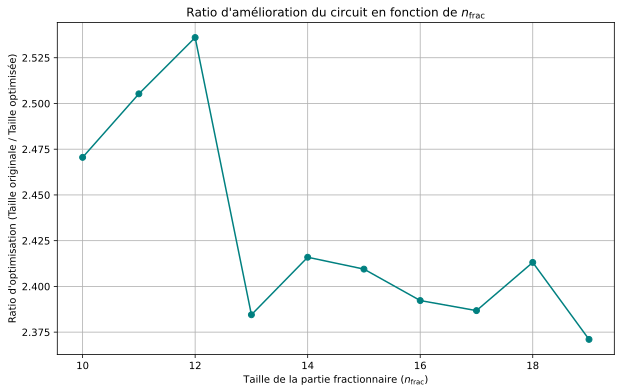

In [12]:
N_START = 10
N_END = 20
N_POINTS = N_END - N_START

n_frac_values = np.arange(N_START, N_END)
N_values = np.arange(N_START + 6, N_END + 6)
ratio = np.zeros(N_POINTS)

for idx, n_frac in enumerate(n_frac_values):
    degree = 2
    at_x = 0.5
    res, invcirc = InvCirc(n_frac, N_values[idx], degree, at_x)
    new_circ = invcirc.copy()
    previous = len(new_circ.gates)
    new_circ = removeUselessControl(new_circ)
    while previous != len(new_circ.gates):
        previous = len(new_circ.gates)
        new_circ = removeUselessControl(new_circ)
    ratio[idx] = len(invcirc.gates)/len(new_circ.gates)

plt.figure(figsize=(10, 6))
plt.plot(n_frac_values, ratio, marker='o', linestyle='-', color='teal')
plt.xlabel('Taille de la partie fractionnaire ($n_{\\text{frac}}$)')
plt.ylabel('Ratio d\'optimisation (Taille originale / Taille optimisée)')
plt.title('Ratio d\'amélioration du circuit en fonction de $n_{\\text{frac}}$')
plt.grid(True)
plt.savefig('optimization_ratio_vs_nfrac.png')


In [19]:
import copy
nombre_tests = 10
for i in range(nombre_tests):
    input_random = {j : random.randint(0,1) for j in range(N)}
    
    state_orig = copy.deepcopy(input_random)
    state_opti = copy.deepcopy(input_random)

    val_orig = invcirc.run(state_orig)
    val_opti = new_circ.run(state_opti)
    
    result_orig = getValue(val_orig, res)
    result_opti = getValue(val_opti, res) 
    
    assert(result_orig == result_opti), f"Échec au test {i+1} : Les résultats diffèrent. Original: {result_orig}, Optimisé: {result_opti}"

print(f"Test de robustesse réussi sur {nombre_tests} entrées aléatoires : Les circuits sont logiquement équivalents.")

AssertionError: 


### 1.2.3 - High-level optimization

Above, we implemented polynomials following the formula:

$$
a\cdot x^3 + b\cdot x^2 + c\cdot x + d.
$$

One can lower the required number of multiplication by instead using the formula:

$$
((a\cdot x + b)\cdot x + c)\cdot x + d
$$

**TODO**

1. Estimate the average gain in circuit size, as a big-O.
2. Implement this alternative presentation to produce an optimized oracle for Inv.

In [20]:
def new_PolyCirc(coeffs, n_frac, N):
    inputs = [i for i in range(N)]
    circ = RevCirc(inputs)

    res = constFPsigned(circ, n_frac, N, coeffs[0])

    for c in coeffs[1:]:
        res = multFPSigned(circ, n_frac, inputs, res)
        bin_c = constFPsigned(circ, n_frac, N, c)
        res = adderFPSigned(circ, n_frac, res, bin_c)

    return res, circ

def new_InvCirc(n_frac, N, degree, at_x):
    x = sympy.symbols('x')
    f = sympy.asin(1/(16*x))
    poly = sum( (f.diff(x, k).subs(x, at_x) / math.factorial(k)) * (x - at_x)**k for k in range(degree+1))
    coeffs = sympy.poly(poly, x).all_coeffs()
    return new_PolyCirc(coeffs, n_frac, N)

res, invcirc = new_InvCirc(n_frac, N, degree, at_x)
    




In [21]:
new_circ = removeUselessControl(invcirc)
print(len(invcirc.gates))
print(len(new_circ.gates))

40744
30639


In [22]:
## Pour récupérer le nombre de gates après convergence
previous = len(new_circ.gates)
new_circ = removeUselessControl(new_circ)
while previous != len(new_circ.gates):
    previous = len(new_circ.gates)
    new_circ = removeUselessControl(new_circ)
print(len(new_circ.gates))

19910


In [23]:
import copy
nombre_tests = 10
for i in range(nombre_tests):
    input_random = {j : random.randint(0,1) for j in range(N)}
    
    state_orig = copy.deepcopy(input_random)
    state_opti = copy.deepcopy(input_random)

    val_orig = invcirc.run(state_orig)
    val_opti = new_circ.run(state_opti)
    
    result_orig = getValue(val_orig, res)
    result_opti = getValue(val_opti, res) 
    
    assert(result_orig == result_opti), f"Échec au test {i+1} : Les résultats diffèrent. Original: {result_orig}, Optimisé: {result_opti}"

print(f"Test de robustesse réussi sur {nombre_tests} entrées aléatoires : Les circuits sont logiquement équivalents.")

Test de robustesse réussi sur 10 entrées aléatoires : Les circuits sont logiquement équivalents.



# 2 - Optimizing the Hamiltonian simulation.

In this section, we will implement the solution discussed in class to
realize $e^{itB}$, where $B$ is


$$
B = \left(
\begin{matrix}
1 & 2 & 0 & 0  &  0 & 0 & 0 & 2\\
2 & 1 & 2 & 0  &  0 & 0 & 0 & 0\\
0 & 2 & 1 & 2  &  0 & 0 & 0 & 0\\
0 & 0 & 2 & 1  &  2 & 0 & 0 & 0
\\
0 & 0 & 0 & 2  &  1 & 2 & 0 & 0\\
0 & 0 & 0 & 0  &  2 & 1 & 2 & 0\\
0 & 0 & 0 & 0  &  0 & 2 & 1 & 2\\
2 & 0 & 0 & 0  &  0 & 0 & 2 & 1
\end{matrix}
\right)
$$

We saw in class how this matrix can be written as

$$
I + 2\cdot I\otimes X + 2\cdot P^{-1}\cdot (I\otimes X)\cdot P
$$

where $P$ is the successor operation modulo $8$:

$$
|x\rangle \mapsto |x+1\rangle
$$

We shall use this decomposition to simulate $e^{itB}$ with

$$
e^{itI}\left( e^{i\frac{t}{n}\cdot I\otimes X}P^{-1} e^{i\frac{t}{n}\cdot I\otimes X} P\right)^n
$$


## 2.1 - Implementing the successor operator

One could of course construct an oracle in V-form and somehow
construct the required operator. For such a simple function, we can
however come up with a more compact representation by considering a
recursive construction.

 * On a single qbit state, the successor operation is just a flip-gate

 * On $|x\rangle = |b_0b_1\ldots b_n\rangle$ with the least significant bit on the right, the action of the successor on $|x\rangle$ is:

   * Flip $b_0$ if all the other $b_j$'s are $1$
   * Perform the successor operation on the $|b_1\ldots b_n\rangle$ subpart

This can be realized with a series of $n$ well-positionned multi-controlled $X$-gates.

**TODO** Implement this operator using QisKit.

In [24]:


def successor(N): # Works on N qbits

    q = QuantumRegister(N)
    qc = QuantumCircuit(q)
    if N == 1:
        qc.x(q)
    else:
        cNx_gate = XGate().control(N-1)
        qc.append(cNx_gate, list(q[1:]) + [q[0]])
        qc.append(successor(N - 1), q[1:])

    # print(qc.draw())
    return Operator(qc)

test = successor(5)




Testing cell

In [25]:

# Size of the register, to change to test (slow at 5 and above)
N = 3

# Value to change. Make sure it fits on the chosen bit size
v = 5

# Do not change below
bs = nat2bl(N,v)

q = QuantumRegister(N)
c = ClassicalRegister(N)
qc = QuantumCircuit(q,c)

for i in range(N):
    if bs[i] == 1: qc.x(q[i])

qc.append(successor(N), q)
qc.measure(q,c)

res = list(getSample(qc, 1).keys())[0]

bl_res = list(reversed(bs2bl(res)))
nat_res = bl2nat(bl_res)

print(f"{v} in binary is {str(bs)}")
print(f"The successor of {v} modulo {2 ** N} is {(v + 1) % (2**N)}")
print(f"The circuit computes {bl_res}, which is in decimal {nat_res}")
if v == (2 ** N) - 1:
    print(f"Looks OK. You might want to try out other values")
elif nat_res == (v + 1) % (2**N):
    print(f"Looks OK. You might want to try out other values, in particular {2 ** N - 1}")
else:
    print(f"Failure!")






5 in binary is [1, 0, 1]
The successor of 5 modulo 8 is 6
The circuit computes [1, 1, 0], which is in decimal 6
Looks OK. You might want to try out other values, in particular 7



## 2.2 - Optimizing Trotterization

We are now ready to simulate $e^{itB}$

**TODO**

1. Remembering what you did in Coding Session #3, when $t=1/2$, implement a circuit realizing $e^{itB}$ up to $10^{-3}$, using the decomposition presented above. How many iterations are necessary for a register of size $3$? and a register of size $5$?

2. The Trotter formula we saw is said to be of first order. If higher-order formulas are potentially involved, the second-order one is very manageable: it says that

$$
e^{it(A+B)} = \left(e^{i\frac{t}{2n}B}e^{i\frac{t}{n}A}e^{i\frac{t}{2n}B}\right)^n + O\left(\frac{t^2}{n^2}\right)
$$

Update your code to take this formula into account: how many steps are now necessary to get to $10^{-3}$?

**Hint**

* There is a subtlety with the endian convention: you might have to flip the ordering of the qubits.
* For the second-order version, the circuit needs only to be modified at the beginning and at the end.

In [26]:

n = 5 # Register size
t = 1/2
a = 1
b = 2

def Bn(n):
    N = 2 ** n
    
    B = [[0 for i in range(N)] for j in range(N)]
    for i in range(N):
        B[i][i] = 1
        if i > 0:
            B[i-1][i] = 2 
            B[i][i-1] = 2
    B[0][N - 1] = 2
    B[N- 1][0] = 2
    return np.array(B)




def IX(qc,q,N):
    qc.rx(-2*b*t/N, q[0])

def P(qc, q):
    qc.append(successor(n),q)

def trotterBn(N,n):
    q = QuantumRegister(n, name="q")
    qc = QuantumCircuit(q)
    qc.global_phase = a*t
    P = successor(n)
    P_gate = P.to_instruction()
    P_inverse = P_gate.inverse()

    for i in range(N):
        
        IX(qc, q, 2*N)

        qc.append(P_inverse, q[::-1])
        IX(qc, q, N)
        qc.append(P_gate, q[::-1]) 

        IX(qc, q, 2*N)

        
    return qc


qc = trotterBn(16, n) # adjust to get to 10^-3
# approx = flipEndian(np.array(Operator.from_circuit(qc)))
approx = np.array(Operator.from_circuit(qc))
exact = linalg.expm(1j * t * Bn(n))
diff = linalg.interpolative.estimate_spectral_norm(exact - approx)
print("Error is", diff)



Error is 0.0010694901252733828



## 2.3 - Computing circuit sizes

**TODO** (give any convincing argument: math, or code)

1. What is the size of the circuit?
2. How would the circuit scale as the size of the register increase? Suppose that the matrix $B$ scales in a homogeneous manner:

$$
\left(
\begin{matrix}
1 & 2 & 0 & 2\\
2 & 1 & 2 & 0\\
0 & 2 & 1 & 2\\
2 & 0 & 2 & 1
\end{matrix}
\right)
\qquad
\left(
\begin{matrix}
1 & 2 & 0 & 0  &  0 & 0 & 0 & 2\\
2 & 1 & 2 & 0  &  0 & 0 & 0 & 0\\
0 & 2 & 1 & 2  &  0 & 0 & 0 & 0\\
0 & 0 & 2 & 1  &  2 & 0 & 0 & 0
\\
0 & 0 & 0 & 2  &  1 & 2 & 0 & 0\\
0 & 0 & 0 & 0  &  2 & 1 & 2 & 0\\
0 & 0 & 0 & 0  &  0 & 2 & 1 & 2\\
2 & 0 & 0 & 0  &  0 & 0 & 2 & 1
\end{matrix}
\right)
$$

$$
\left(
\begin{matrix}
1 & 2 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 2\\
2 & 1 & 2 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 2 & 1 & 2  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 2 & 1  &  2 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0
\\
0 & 0 & 0 & 2  &  1 & 2 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  2 & 1 & 2 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 2 & 1 & 2  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 2 & 1  &  2 & 0 & 0 & 0  &  0 & 0 & 0 & 0
\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 2  &  1 & 2 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  2 & 1 & 2 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 2 & 1 & 2  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 2 & 1  &  2 & 0 & 0 & 0
\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 2  &  1 & 2 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  2 & 1 & 2 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 2 & 1 & 2\\
2 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 2 & 1\\
\end{matrix}
\right)
$$

3. In the last question of Coding Session #3, despite the exponential
explosion of number of Pauli string in the decomposition of the
Hermitian matrix, we derived that Trotterization would eventually beat
a naive exact decomposition. The size of the circuit at this turning
point was however very large: with the optimizations discussed here,
at what register and circuit size do we beat a naive decomposition?

**Hint**

* For the sake of this question, you can consider that multi-controlled
  $X$-gates have a gate-count of $1$.

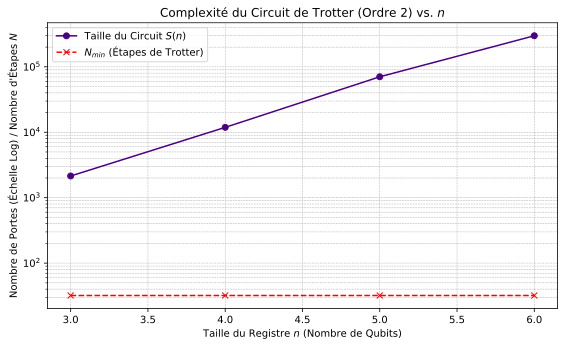

In [30]:
def get_gate_count(qc):
    """Décompose et compte le nombre total de portes élémentaires (Rx, Rz, CX)."""
    # Décompose les instructions composées (P_gate, P_inverse)
    decomposed_qc = qc.decompose() 
    # Transpile vers la base standard pour un comptage précis
    transpiled_qc = transpile(decomposed_qc, basis_gates=['rx', 'rz', 'cx', 'u3'])
    count_dict = transpiled_qc.count_ops()
    return sum(count_dict.values())


registre_size = np.arange(3, 7)
size = len(registre_size)
N_values = np.zeros(size)
gate_counts = np.zeros(size)

for idx, registre in enumerate(registre_size):
    pas_trotter = 1
    registre = int(registre)
    qc = trotterBn(pas_trotter, registre)
    approx = np.array(Operator.from_circuit(qc))
    exact = linalg.expm(1j * t * Bn(registre))
    diff = linalg.interpolative.estimate_spectral_norm(exact - approx)
    while diff > 10**(-3):
        pas_trotter *=2
        qc = trotterBn(pas_trotter, registre)
        approx = np.array(Operator.from_circuit(qc))
        exact = linalg.expm(1j * t * Bn(registre))
        diff = linalg.interpolative.estimate_spectral_norm(exact - approx)
    N_values[idx] = pas_trotter
    gate_counts[idx] = get_gate_count(qc)
fig, ax = plt.subplots(figsize=(8, 5))

# Trace la taille du circuit (Complexité)
ax.plot(registre_size, gate_counts, marker='o', linestyle='-', color='indigo', label='Taille du Circuit $S(n)$')

# Trace le nombre d'étapes (Efficacité)
ax.plot(registre_size, N_values, marker='x', linestyle='--', color='red', label='$N_{min}$ (Étapes de Trotter)')


ax.set_xlabel('Taille du Registre $n$ (Nombre de Qubits)')
ax.set_ylabel('Nombre de Portes (Échelle Log) / Nombre d\'Étapes $N$')
ax.set_title('Complexité du Circuit de Trotter (Ordre 2) vs. $n$')
ax.set_yscale('log') # Utilisation de l'échelle log pour la complexité
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()

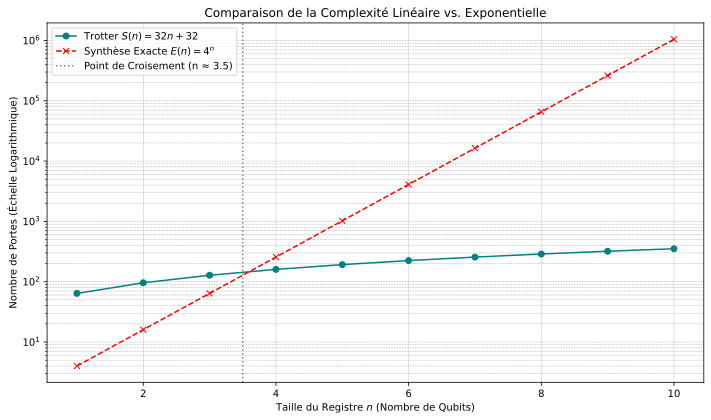

In [33]:
n_values = np.arange(1, 11)

# Définition des fonctions
def S_n(n):
    # Coût Trotter simplifié (Linéaire)
    return 32 * n + 32

def E_n(n):
    # Coût de la synthèse exacte (Exponentielle)
    return 4**n

# Calcul des valeurs
S_values = S_n(n_values)
E_values = E_n(n_values)

# Création du plot avec échelle logarithmique
fig, ax = plt.subplots(figsize=(10, 6))

# Tracé du coût linéaire (Trotter)
ax.plot(n_values, S_values, marker='o', linestyle='-', color='teal', label=r'Trotter $S(n) = 32n + 32$')

# Tracé du coût exponentiel (Synthèse exacte)
ax.plot(n_values, E_values, marker='x', linestyle='--', color='red', label=r'Synthèse Exacte $E(n) = 4^n$')

# Échelle logarithmique sur l'axe Y
ax.set_yscale('log')

# Ajout du point de croisement (entre n=3 et n=4)
ax.axvline(x=3.5, color='gray', linestyle=':', label='Point de Croisement (n ≈ 3.5)')

# Ajout des étiquettes
ax.set_xlabel('Taille du Registre $n$ (Nombre de Qubits)')
ax.set_ylabel('Nombre de Portes (Échelle Logarithmique)')
ax.set_title('Comparaison de la Complexité Linéaire vs. Exponentielle')

ax.legend()
ax.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# 3 - A Complete HHL Algorithm

This last part reflects on all of the course. We discussed how to
encode the HHL algorithm globally, then we delved into the concrete
problem of encoding each subpart and tested some approaches and
possible optimizations. If these are not necessarily the best one can
do (this is still an active research subject!), it nonetheless gives a
possible implementation worth studying.

**Task**

Consider a Hermitian matrix of the $B$-shape above, acting on 7
quantum bits (therefore a $128\times 128$ matrix).

Assume that we are given $7$ qbits in state $|b\rangle$.

**TODO** Gather all the knowledge you learned in this class, and give your
best-guess estimate on the resources (gates and ancillas) required to
run the HHL algorithm to build the state $|x\rangle$ where $x$ is the
solution of $A\cdot x = b$.

**Requirements**

* The allowed gates are here (not counting global phase)

$$ X, Y, Z, T, H, R_x(\theta), R_z(\theta), R_y(\theta), \textit{CNOT}, \textit{Toffoli} $$

In particular, you will have to decompose the multi-controlled
$X$-gates (or, at least, estimate the resources needed for them).

* The  precision we want for the solution $|x\rangle$ is $10^{-3}$ 


**Instructions**

* Work out each subppart of the circuit separately: QFT, Hamiltonian
  simulation, oracle, and give enough details so that I understand how
  you reached the stated gates/ancilla count. The justification can be
  math, drawing, code... I just need to be convinced.

* The requirements are voluntarily imprecise and hiding trade-offs:
  you can use this at your advantage. I however want you to spell out
  clearly the trade-offs and choices you make.

* Bonus point if you describe a particularly compact implementation
  with an additional optimization somewhere.
